In [62]:
!pip3 install kneed

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [63]:
import sys
sys.path.append("../../")

from src.statistics.cointegration import find_cointegrated_pairs, analyze_pairs, plot_cointegration_heatmap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

`preference` postiv -> less cluster 

In [64]:
p_threshold = 0.05
min_pairs = 20

window_shifts = 12
shift_size = 1

entry_threshold = 2.0
exit_threshold = 0.5
window1 = 5 
window2 = 60

preference = None

# on ftse, -50 ±3 Cluster

base_input_path = "../../data/raw/" 
input_filename = "ftse_daily.parquet" 
base_output_path = "../../data/results/" 
output_filename = "Cluster2_Z-Score_Sliding.parquet"

In [65]:
TRAIN_START = pd.Timestamp('2021-02-02')
TRAIN_END = pd.Timestamp('2024-01-01')
TEST_END = pd.Timestamp('2025-01-01')
TRADING_DAYS_PER_YEAR = 252

DATE_CONFIG = {
    'TRAIN_START': TRAIN_START,
    'TRAIN_END': TRAIN_END,
    'TEST_END': TEST_END,
    'TRADING_DAYS_PER_YEAR': TRADING_DAYS_PER_YEAR  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

# Plot settings
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [66]:
def load_and_prepare_data(file_path):
    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    price_matrix = price_matrix.ffill().bfill()
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, symbols

##### Loade Price Data

In [67]:
input_data_path = f"{base_input_path}{input_filename}"
output_path = f"{base_output_path}{output_filename}"

price_matrix, symbols = load_and_prepare_data(input_data_path)

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 98
Total trading days: 987



$$ \text{Rendite} = \frac{1}{T} \sum_{t=1}^{T} \frac{P_t - P_{t-1}}{P_{t-1}} \times \text{Trading days per year} $$


$$ \text{Volatilität} = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} \left( \frac{P_t - P_{t-1}}{P_{t-1}} - \mu \right)^2} \times \sqrt{\text{Trading days per year}} $$


In [68]:
def calculate_metrics(price_matrix):
    returns = price_matrix.pct_change().mean() * DATE_CONFIG['TRADING_DAYS_PER_YEAR']
    metrics = pd.DataFrame(returns, columns=['returns'])
    metrics['volatility'] = price_matrix.pct_change().std() * np.sqrt(DATE_CONFIG['TRADING_DAYS_PER_YEAR'])
    return metrics

##### Validate metrics

In [69]:
metrics = calculate_metrics(price_matrix)
print("Erste 5 Zeilen der Metriken:")
print(metrics.head())
print("\nBeschreibung der Metriken:")
print(metrics.describe())

Erste 5 Zeilen der Metriken:
         returns  volatility
symbol                      
AAF.L   0.182975    0.336650
AAL.L   0.118102    0.403779
ABF.L   0.027631    0.250263
ADM.L   0.041431    0.272685
AHT.L   0.127775    0.317220

Beschreibung der Metriken:
         returns  volatility
count  98.000000   98.000000
mean    0.105918    0.273853
std     0.115051    0.059466
min    -0.111803    0.154173
25%     0.027157    0.236768
50%     0.094072    0.265661
75%     0.171602    0.306870
max     0.552316    0.437505


##### Scale Transform
The StandardScaler transforms our features (returns and volatility) to have zero mean and unit variance, which eliminates the scale difference between our variables and prevents higher magnitude features from dominating. This standardization is crucial for many machine learning algorithms as it ensures that all features contribute equally to the model and helps prevent numerical instabilities during the optimization process.

In [70]:
def scale_metrics(metrics):
    scaler = StandardScaler()
    scaled = pd.DataFrame(
        scaler.fit_transform(metrics),
        columns=metrics.columns,
        index=metrics.index
    )
    return scaled

In [71]:
X = scale_metrics(metrics)
print("Erste 5 Zeilen der skalierten Daten:")
print(X.head())
print("\nBeschreibung der skalierten Daten:")
print(X.describe())

Erste 5 Zeilen der skalierten Daten:
         returns  volatility
symbol                      
AAF.L   0.673205    1.061455
AAL.L   0.106443    2.196133
ABF.L  -0.683956   -0.398740
ADM.L  -0.563392   -0.019739
AHT.L   0.190950    0.733035

Beschreibung der skalierten Daten:
            returns    volatility
count  9.800000e+01  9.800000e+01
mean  -1.586033e-17 -5.092298e-16
std    1.005141e+00  1.005141e+00
min   -1.902126e+00 -2.022928e+00
25%   -6.880970e-01 -6.268293e-01
50%   -1.034959e-01 -1.384636e-01
75%    5.738475e-01  5.580961e-01
max    3.899964e+00  2.766195e+00


In [72]:
def get_top_pairs(X, ap, price_matrix, min_pairs=min_pairs, p_threshold=p_threshold):
    scores = []
    
    for cluster_id in np.unique(ap.labels_):
        cluster_mask = ap.labels_ == cluster_id
        cluster_symbols = X.index[cluster_mask]
        center = X.iloc[ap.cluster_centers_indices_[cluster_id]]
        
        for i in range(len(cluster_symbols)):
            for j in range(i+1, len(cluster_symbols)):
                symbol1, symbol2 = cluster_symbols[i], cluster_symbols[j]
                
                dist1 = np.linalg.norm(X.loc[symbol1] - center)
                dist2 = np.linalg.norm(X.loc[symbol2] - center)
                center_dist = (dist1 + dist2) / 2
                
                profile_diff = np.linalg.norm(X.loc[symbol1] - X.loc[symbol2])
                
                series1 = price_matrix[symbol1]
                series2 = price_matrix[symbol2]
                score, pvalue, _ = coint(series1, series2)
                
                if pvalue < p_threshold:
                    scores.append({
                        'pair': (symbol1, symbol2),
                        'center_dist': center_dist,
                        'profile_diff': profile_diff,
                        'pvalue': pvalue,
                        'cluster': cluster_id
                    })

    scores_df = pd.DataFrame(scores)
    
    # Überprüfen, ob die DataFrame leer ist
    if len(scores_df) == 0:
        print(f"Keine cointegrierten Paare mit p-value < {p_threshold} gefunden.")
        return [], pd.DataFrame()
    
    scores_df['center_dist_norm'] = (scores_df['center_dist'] - scores_df['center_dist'].min()) / \
                                   (scores_df['center_dist'].max() - scores_df['center_dist'].min())
    scores_df['profile_diff_norm'] = (scores_df['profile_diff'] - scores_df['profile_diff'].min()) / \
                                    (scores_df['profile_diff'].max() - scores_df['profile_diff'].min())

    scores_df['combined_score'] = 0.6 * scores_df['center_dist_norm'] + \
                                 0.4 * scores_df['profile_diff_norm']
    
    scores_df = scores_df.sort_values('combined_score')
    
    while len(scores_df) < min_pairs and p_threshold < 0.1:
        p_threshold += 0.05
        scores = []
        for cluster_id in np.unique(ap.labels_):
            cluster_mask = ap.labels_ == cluster_id
            cluster_symbols = X.index[cluster_mask]
            center = X.iloc[ap.cluster_centers_indices_[cluster_id]]
            
            for i in range(len(cluster_symbols)):
                for j in range(i+1, len(cluster_symbols)):
                    symbol1, symbol2 = cluster_symbols[i], cluster_symbols[j]
                    dist1 = np.linalg.norm(X.loc[symbol1] - center)
                    dist2 = np.linalg.norm(X.loc[symbol2] - center)
                    center_dist = (dist1 + dist2) / 2
                    profile_diff = np.linalg.norm(X.loc[symbol1] - X.loc[symbol2])
                    score, pvalue, _ = coint(series1, series2)
                    
                    if pvalue < p_threshold:
                        scores.append({
                            'pair': (symbol1, symbol2),
                            'center_dist': center_dist,
                            'profile_diff': profile_diff,
                            'pvalue': pvalue,
                            'cluster': cluster_id
                        })
        
        scores_df = pd.DataFrame(scores)
        if len(scores) > 0:
            scores_df['center_dist_norm'] = (scores_df['center_dist'] - scores_df['center_dist'].min()) / \
                                          (scores_df['center_dist'].max() - scores_df['center_dist'].min())
            scores_df['profile_diff_norm'] = (scores_df['profile_diff'] - scores_df['profile_diff'].min()) / \
                                           (scores_df['profile_diff'].max() - scores_df['profile_diff'].min())
            scores_df['combined_score'] = 0.6 * scores_df['center_dist_norm'] + \
                                        0.4 * scores_df['profile_diff_norm']
            scores_df = scores_df.sort_values('combined_score')
    
    num_pairs = min(len(scores_df), min_pairs)
    print(f"Found {len(scores_df)} pairs with p-value < {p_threshold}")
    return scores_df['pair'].tolist()[:num_pairs], scores_df[:num_pairs]

# Affinity Propagation Clustering

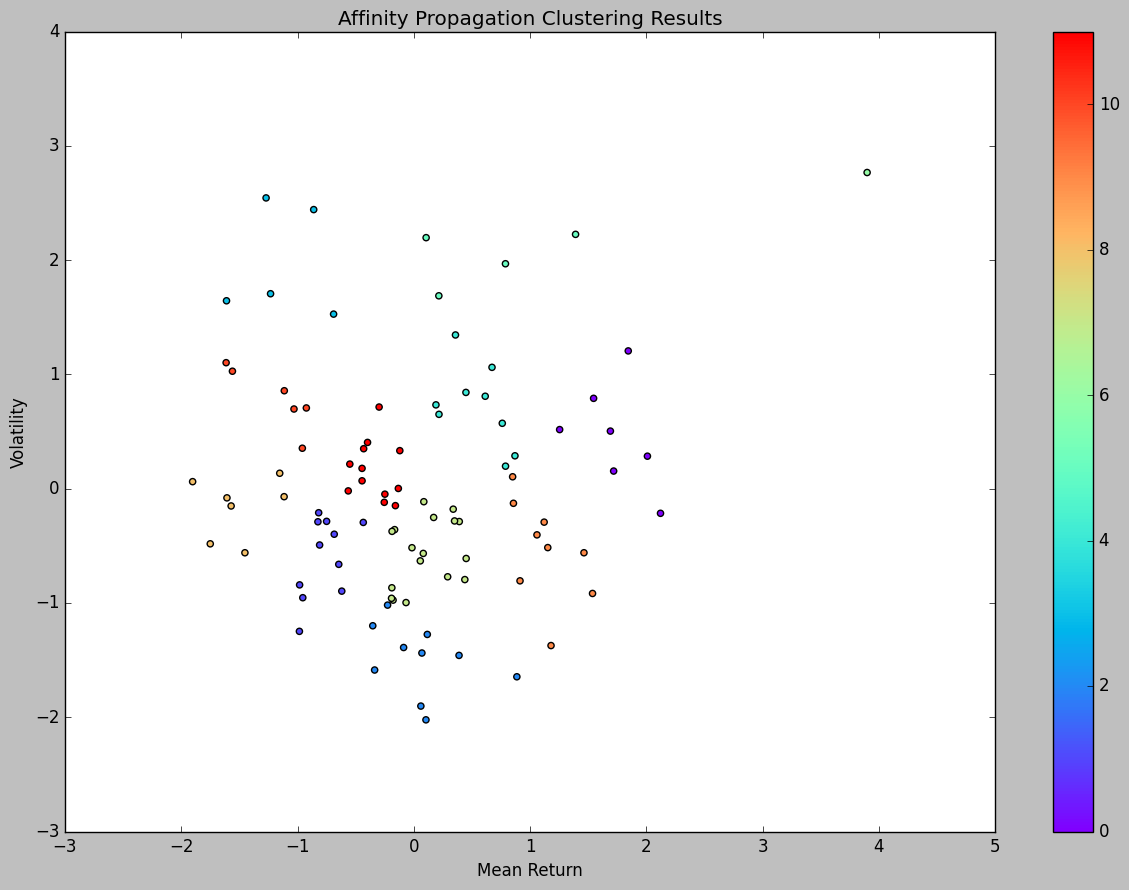

Found 43 pairs with p-value < 0.05

Top pairs details:
                pair  center_dist  profile_diff    pvalue  combined_score  \
30    (SDR.L, SPX.L)     0.039779      0.079558  0.036332        0.018439   
0     (ABF.L, BKG.L)     0.078640      0.157280  0.023908        0.106946   
22  (LGEN.L, SBRY.L)     0.165391      0.330782  0.000359        0.304524   
12  (EXPN.L, LGEN.L)     0.219993      0.223420  0.017537        0.324879   
38   (LAND.L, WTB.L)     0.176599      0.353197  0.025810        0.330049   
33   (LAND.L, RIO.L)     0.231029      0.268073  0.017330        0.360858   
5   (AUTO.L, EXPN.L)     0.218110      0.323995  0.017842        0.370699   
40   (RIO.L, WEIR.L)     0.234387      0.418362  0.013752        0.437455   
16   (IMI.L, SBRY.L)     0.232493      0.464986  0.004226        0.457350   
41    (RIO.L, WPP.L)     0.271601      0.359730  0.048819        0.458311   
32   (CTEC.L, WPP.L)     0.366768      0.135161  0.047398        0.475804   
17    (INF.L, MNG.L) 

In [73]:
if preference is None:
    ap = AffinityPropagation()
else:
    ap = AffinityPropagation(preference=preference)
ap.fit(X)
labels1 = ap.predict(X) #1

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

top_pairs, scores_df = get_top_pairs(X, ap, price_matrix, min_pairs=min_pairs)

print("\nTop pairs details:")
if not scores_df.empty:
    print(scores_df[['pair', 'center_dist', 'profile_diff', 'pvalue', 'combined_score', 'cluster']])
else:
    print("Keine Paare gefunden.")

Größe X_ap: (98, 2)
Größe labels2: (98,)
Ursprüngliche Anzahl Cluster: 12
Cluster mit mehr als einer Aktie: 11
Entfernte Einzelaktien-Cluster: 1


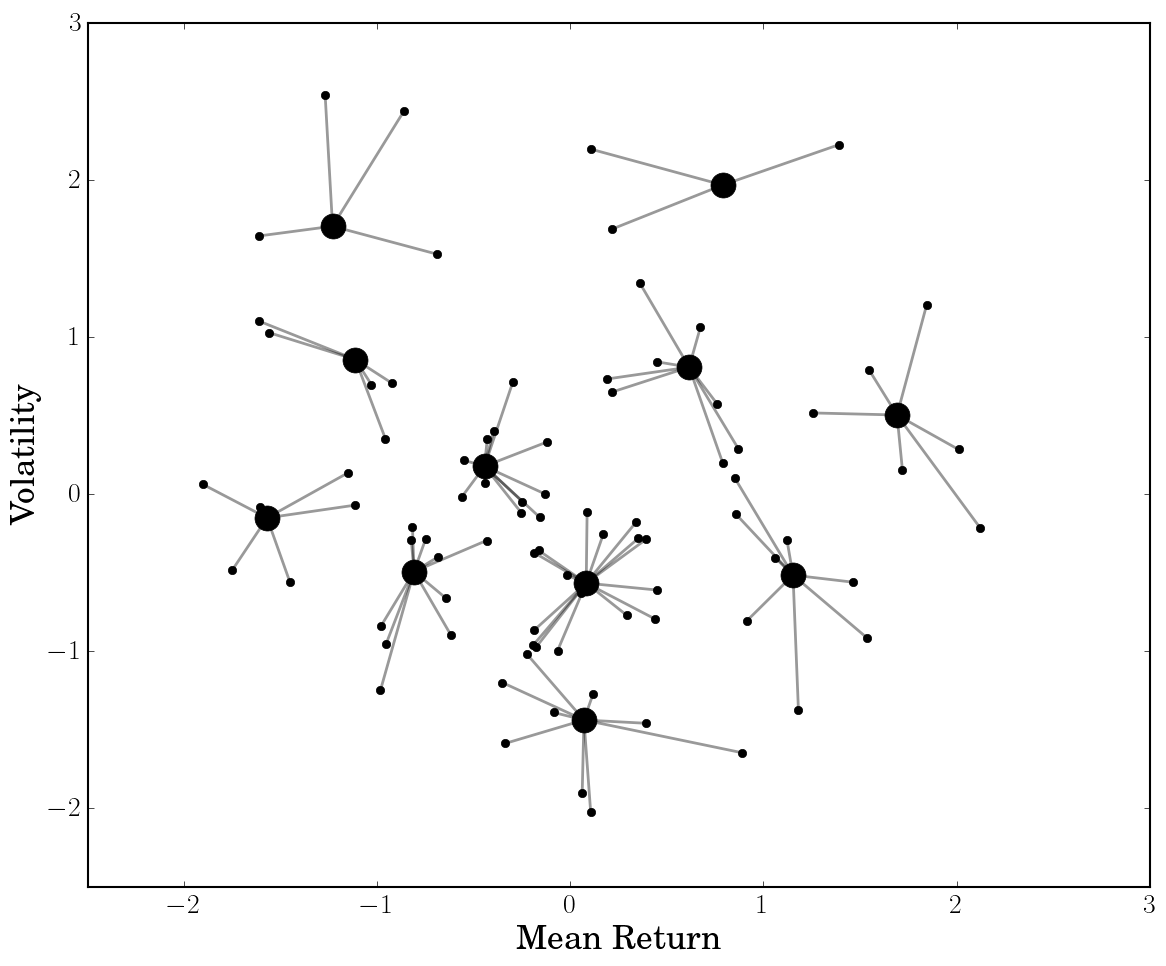


Cluster-Zusammensetzung (nur Cluster mit >1 Aktie):
Cluster 7: 17 Aktien (Indizes: [ 7  8  9 20 29 40 47 48 53 56 59 63 66 75 81 85 93])
Cluster 11: 12 Aktien (Indizes: [ 3 15 24 41 51 52 70 72 90 95 96 97])
Cluster 1: 11 Aktien (Indizes: [ 2 14 25 26 36 38 49 55 64 71 92])
Cluster 2: 10 Aktien (Indizes: [ 5 12 16 31 35 61 69 88 89 91])
Cluster 4: 9 Aktien (Indizes: [ 0  4 17 18 27 33 34 43 80])
Cluster 9: 9 Aktien (Indizes: [10 22 39 44 46 54 68 77 79])
Cluster 0: 7 Aktien (Indizes: [11 13 21 45 57 62 86])
Cluster 8: 7 Aktien (Indizes: [23 58 76 78 83 84 94])
Cluster 10: 6 Aktien (Indizes: [19 37 65 67 74 82])
Cluster 3: 5 Aktien (Indizes: [28 30 32 50 87])
Cluster 5: 4 Aktien (Indizes: [ 1  6 42 60])


In [74]:
from itertools import cycle
import numpy as np

# LaTeX Konfiguration
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# Extract the cluster centers and labels
cci = ap.cluster_centers_indices_
labels2 = ap.labels_

# Sicherstellen, dass X_ap und labels2 die gleiche Länge haben
X_ap = np.asarray(X)
print(f"Größe X_ap: {X_ap.shape}")
print(f"Größe labels2: {labels2.shape}")

# Überprüfung und Korrektur der Array-Größen
if len(X_ap) != len(labels2):
    print(f"WARNUNG: Array-Größen stimmen nicht überein!")
    print(f"X_ap hat {len(X_ap)} Elemente, labels2 hat {len(labels2)} Elemente")
    # Nehme die kleinere Größe als gemeinsame Basis
    min_size = min(len(X_ap), len(labels2))
    X_ap = X_ap[:min_size]
    labels2 = labels2[:min_size]
    print(f"Arrays auf Größe {min_size} angepasst")

# Filtere Cluster mit nur einer Aktie heraus
cluster_sizes = {}
valid_cluster_indices = np.unique(labels2)

for k in valid_cluster_indices:
    cluster_members = labels2 == k
    cluster_size = np.sum(cluster_members)
    cluster_sizes[k] = cluster_size

# Nur Cluster mit mehr als einer Aktie behalten
valid_clusters = [k for k, size in cluster_sizes.items() if size > 1]
filtered_clusters = len(valid_clusters)

print(f'Ursprüngliche Anzahl Cluster: {len(valid_cluster_indices)}')
print(f'Cluster mit mehr als einer Aktie: {filtered_clusters}')
print(f'Entfernte Einzelaktien-Cluster: {len(valid_cluster_indices) - filtered_clusters}')

# Plot erstellen
plt.close('all')
fig = plt.figure(figsize=(12, 10), facecolor='white')
ax = fig.add_subplot(111, facecolor='white')

# Styling
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.patch.set_facecolor('white')
fig.patch.set_facecolor('white')

# Nur valide Cluster plotten
for k in valid_clusters:
    cluster_members = labels2 == k
    
    # Überprüfe, ob der Cluster-Index gültig ist
    if k < len(cci):
        cluster_center = X_ap[cci[k]]
    else:
        # Falls Index ungültig, berechne Zentrum manuell
        cluster_center = np.mean(X_ap[cluster_members], axis=0)
    
    # Plot Cluster-Mitglieder
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], '.', color='black', markersize=12)
    
    # Plot Cluster-Zentrum
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor='black', markersize=18)
    
    # Verbindungslinien
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color='black', alpha=0.4, linewidth=2)

# Optional: Einzelaktien als graue Punkte
show_singles = True
if show_singles:
    single_clusters = [k for k, size in cluster_sizes.items() if size == 1]
    for k in single_clusters:
        cluster_members = labels2 == k
        plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], '.', color='lightgray', markersize=8, alpha=0.6)

# Feste Achsenbereiche für bessere Übersicht
ax.set_xlim(-2.5, 3)
ax.set_ylim(-2.5, 3)

# Labels
plt.xlabel(r'Mean Return', fontsize=24)
plt.ylabel(r'Volatility', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()

# Cluster-Zusammensetzung ausgeben
print("\nCluster-Zusammensetzung (nur Cluster mit >1 Aktie):")
for k in sorted(valid_clusters, key=lambda x: cluster_sizes[x], reverse=True):
    cluster_members = labels2 == k
    cluster_indices = np.where(cluster_members)[0]
    print(f"Cluster {k}: {cluster_sizes[k]} Aktien (Indizes: {cluster_indices})")

In [75]:
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())

cluster_size_limit = 1000
counts = clustered_series_ap.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print("Number of clusters:", len(ticker_count))
print("Number of Pairs:", (ticker_count*(ticker_count-1)).sum())

Number of clusters: 11
Number of Pairs: 894


Analyzing pairs: 100%|██████████| 21/21 [00:00<00:00, 76.55it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 21


Analyzing pairs: 100%|██████████| 55/55 [00:00<00:00, 82.45it/s]



Analysis complete!
Found 2 cointegrated pairs
Total pairs analyzed: 55

Cluster 1 pairs:
ABF.L - BKG.L
PHNX.L - RKT.L


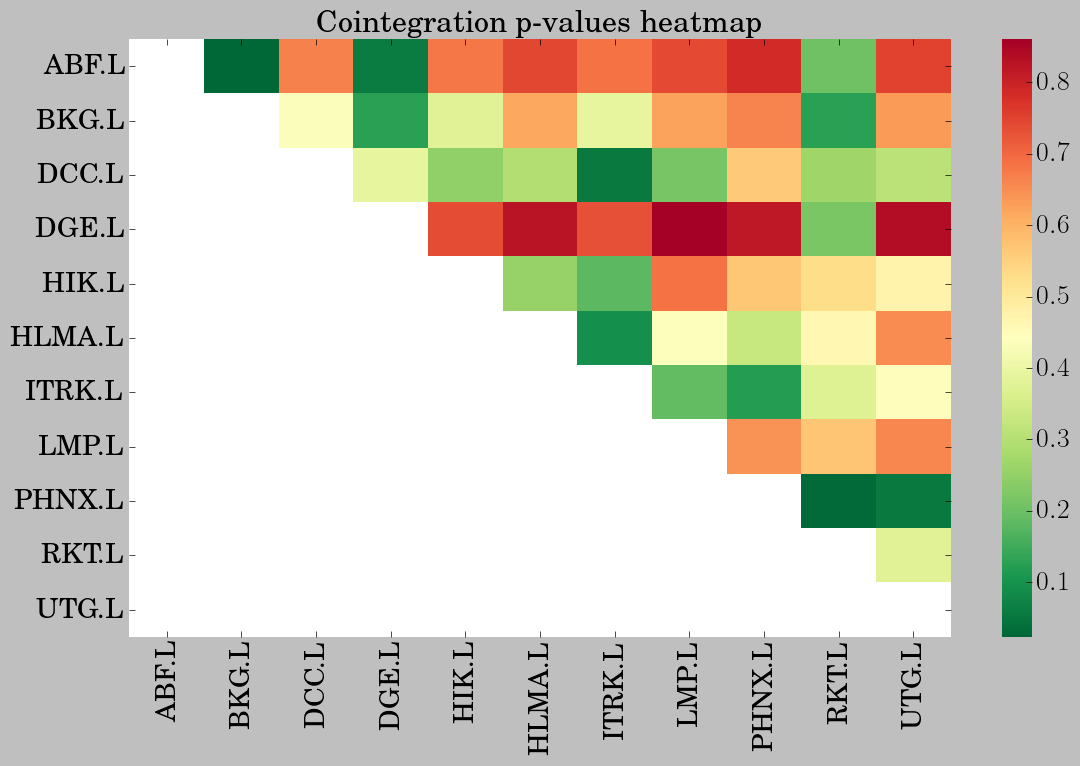

Analyzing pairs: 100%|██████████| 45/45 [00:00<00:00, 83.08it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 45


Analyzing pairs: 100%|██████████| 10/10 [00:00<00:00, 81.63it/s]



Analysis complete!
Found 1 cointegrated pairs
Total pairs analyzed: 10

Cluster 3 pairs:
FRES.L - STJ.L


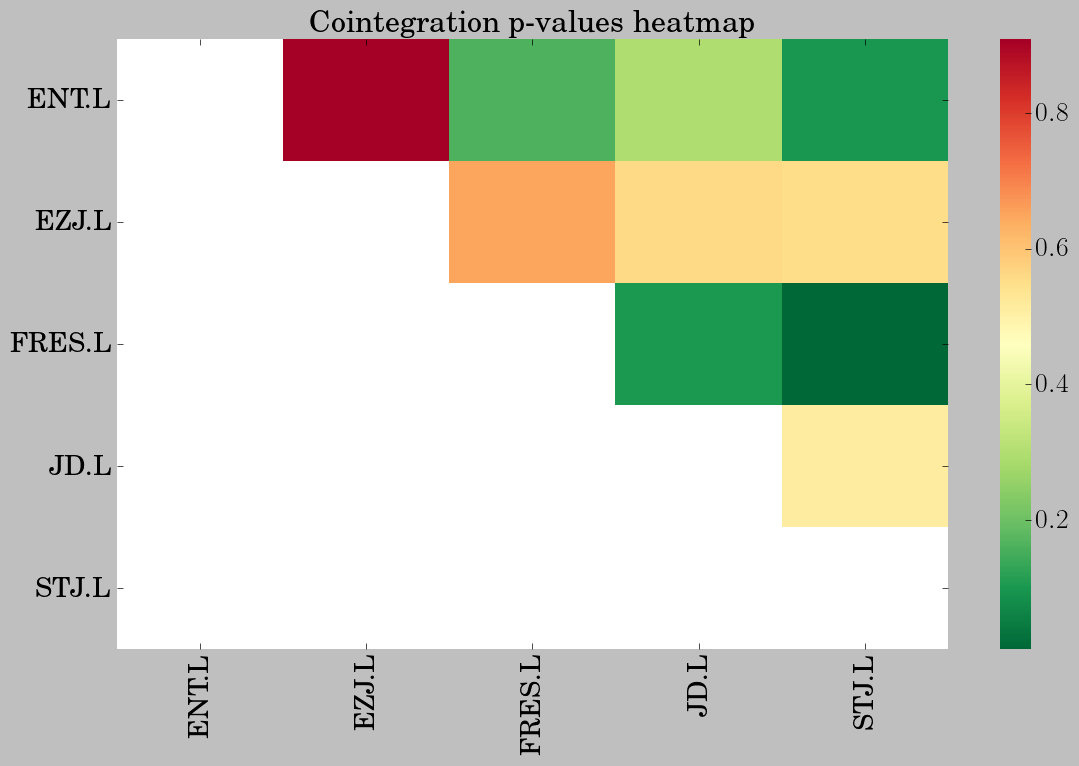

Analyzing pairs: 100%|██████████| 36/36 [00:00<00:00, 82.61it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 36


Analyzing pairs: 100%|██████████| 6/6 [00:00<00:00, 83.17it/s]



Analysis complete!
Found 1 cointegrated pairs
Total pairs analyzed: 6

Cluster 5 pairs:
AAL.L - MRO.L


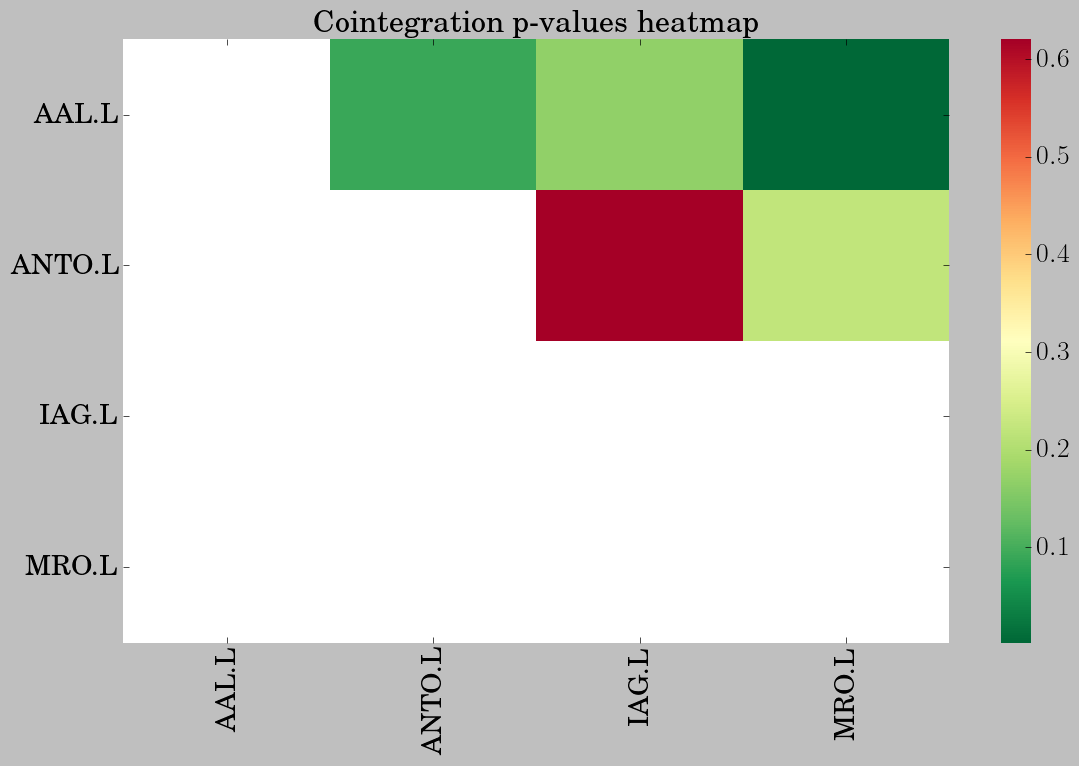

Analyzing pairs: 100%|██████████| 136/136 [00:01<00:00, 81.63it/s]



Analysis complete!
Found 26 cointegrated pairs
Total pairs analyzed: 136

Cluster 7 pairs:
AUTO.L - AV.L
AUTO.L - EXPN.L
AUTO.L - NXT.L
AV.L - LSEG.L
AV.L - PSH.L
AZN.L - HSX.L
AZN.L - SSE.L
CCH.L - IMI.L
EXPN.L - LGEN.L
HSX.L - INF.L
HSX.L - SMIN.L
IMI.L - NXT.L
IMI.L - SBRY.L
INF.L - MNG.L
LGEN.L - LSEG.L
LGEN.L - MNG.L
LGEN.L - NXT.L
LGEN.L - PSH.L
LGEN.L - SBRY.L
LGEN.L - SMIN.L
LGEN.L - SSE.L
LGEN.L - UU.L
LSEG.L - MNG.L
MNG.L - NXT.L
MNG.L - PSH.L
MNG.L - UU.L


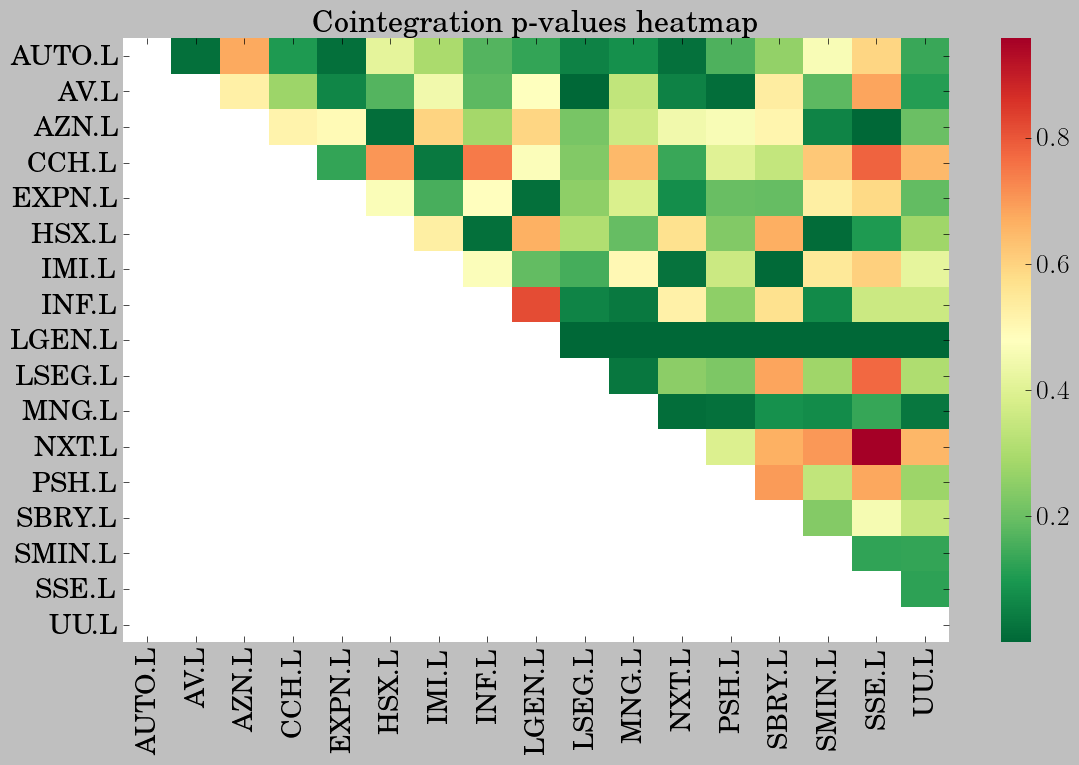

Analyzing pairs: 100%|██████████| 21/21 [00:00<00:00, 81.38it/s]



Analysis complete!
Found 1 cointegrated pairs
Total pairs analyzed: 21

Cluster 8 pairs:
SDR.L - SPX.L


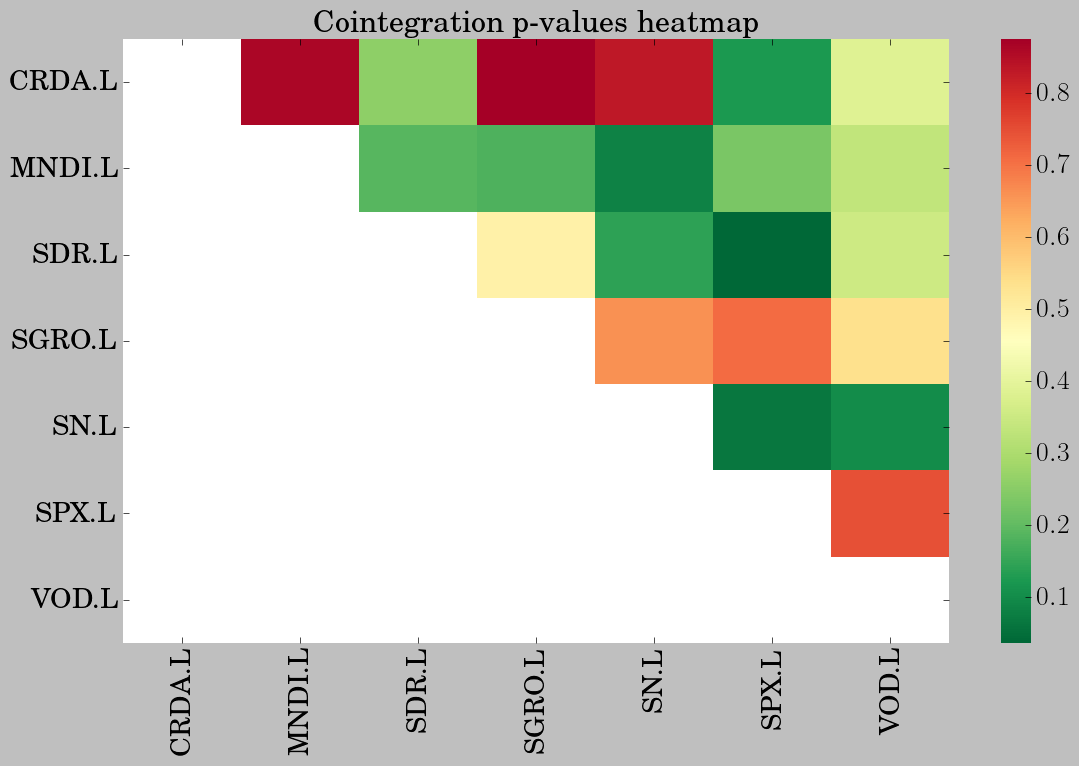

Analyzing pairs: 100%|██████████| 36/36 [00:00<00:00, 82.52it/s]



Analysis complete!
Found 1 cointegrated pairs
Total pairs analyzed: 36

Cluster 9 pairs:
CPG.L - HSBA.L


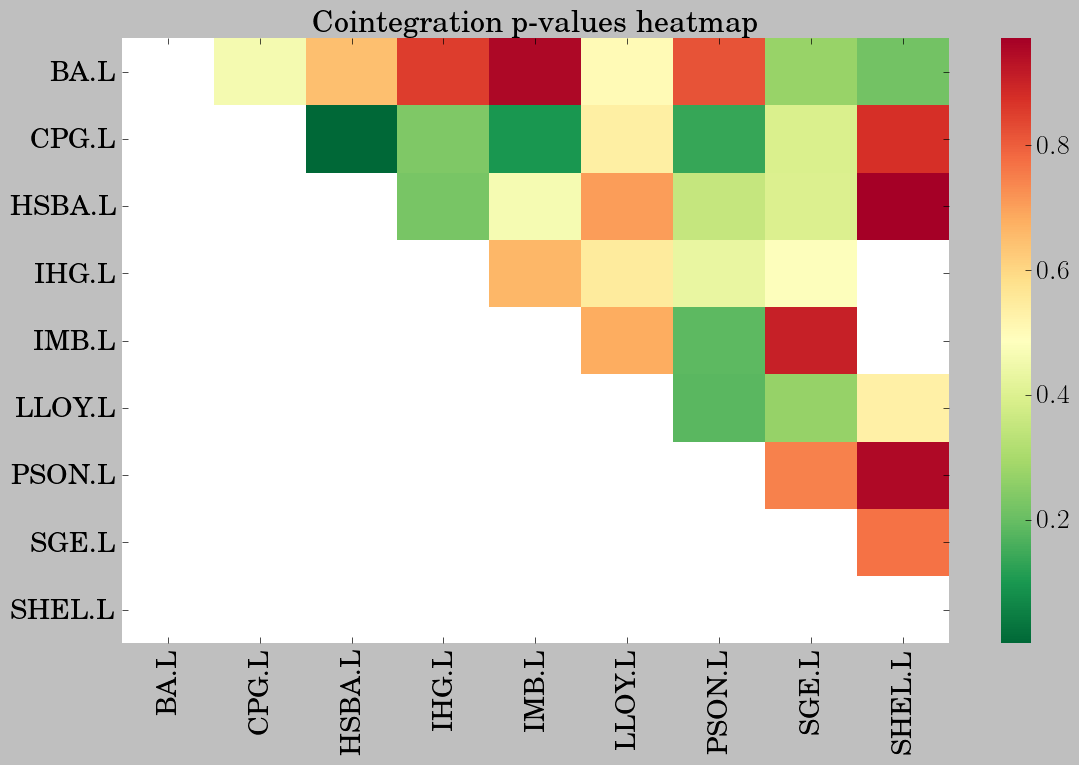

Analyzing pairs: 100%|██████████| 15/15 [00:00<00:00, 82.63it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 15


Analyzing pairs: 100%|██████████| 66/66 [00:00<00:00, 79.57it/s]



Analysis complete!
Found 11 cointegrated pairs
Total pairs analyzed: 66

Cluster 11 pairs:
CTEC.L - WPP.L
LAND.L - RIO.L
LAND.L - RMV.L
LAND.L - TW.L
LAND.L - WEIR.L
LAND.L - WPP.L
LAND.L - WTB.L
RIO.L - RMV.L
RIO.L - WEIR.L
RIO.L - WPP.L
RMV.L - WPP.L


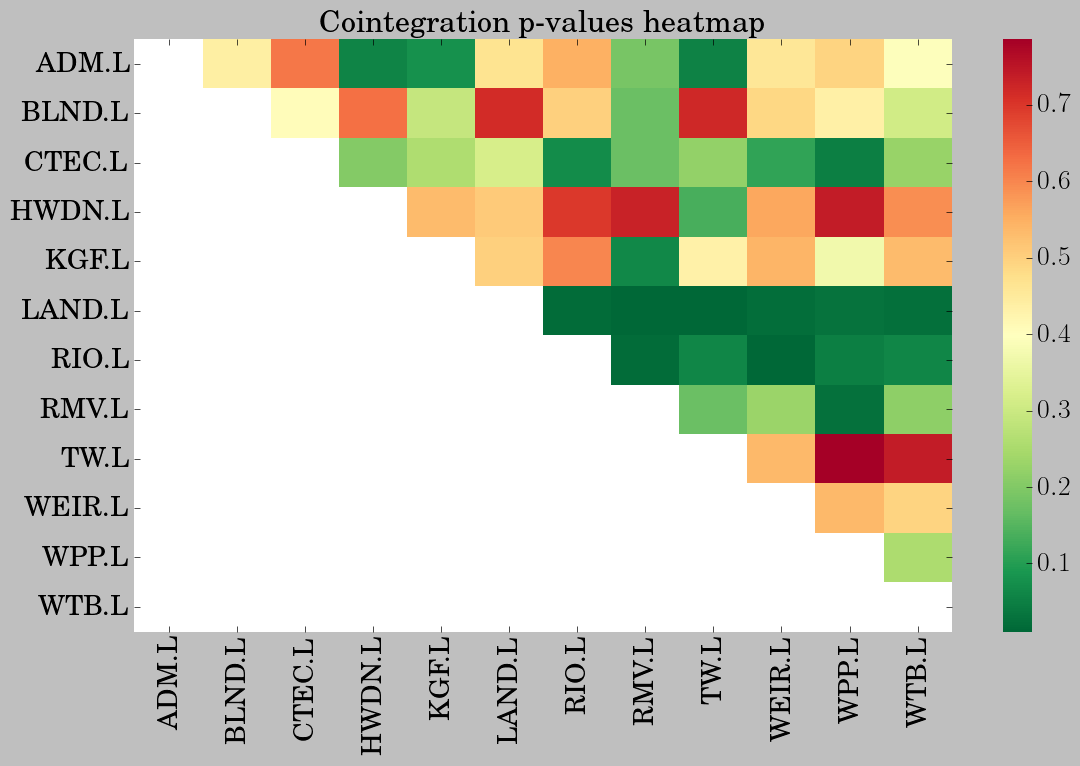

In [76]:
all_pairs_with_clusters = []

for cluster_id in np.unique(ap.labels_):
    cluster_mask = ap.labels_ == cluster_id
    cluster_symbols = X.index[cluster_mask]
    
    if len(cluster_symbols) > 1:
        cluster_prices = price_matrix[cluster_symbols]
        score_matrix, pvalue_matrix, pairs, _ = analyze_pairs(
            cluster_prices,
            pvalue_threshold=p_threshold
        )
        
        if len(pairs) > 0:
            for pair in pairs:
                all_pairs_with_clusters.append({
                    'pair': pair,
                    'cluster': cluster_id
                })
            print(f"\nCluster {cluster_id} pairs:")
            for pair in pairs:
                print(f"{pair[0]} - {pair[1]}")
                
            plot_cointegration_heatmap(pvalue_matrix, cluster_symbols)

all_pairs = [item['pair'] for item in all_pairs_with_clusters]

In [77]:
stocks = np.unique([stock for pair in top_pairs for stock in pair])
X_data = pd.DataFrame(index=X.index, data=X).T  
in_pairs_series = pd.Series(index=stocks, data=[ap.labels_[list(X.index).index(stock)] for stock in stocks])
X_pairs = X_data.T.loc[stocks]

In [78]:
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)

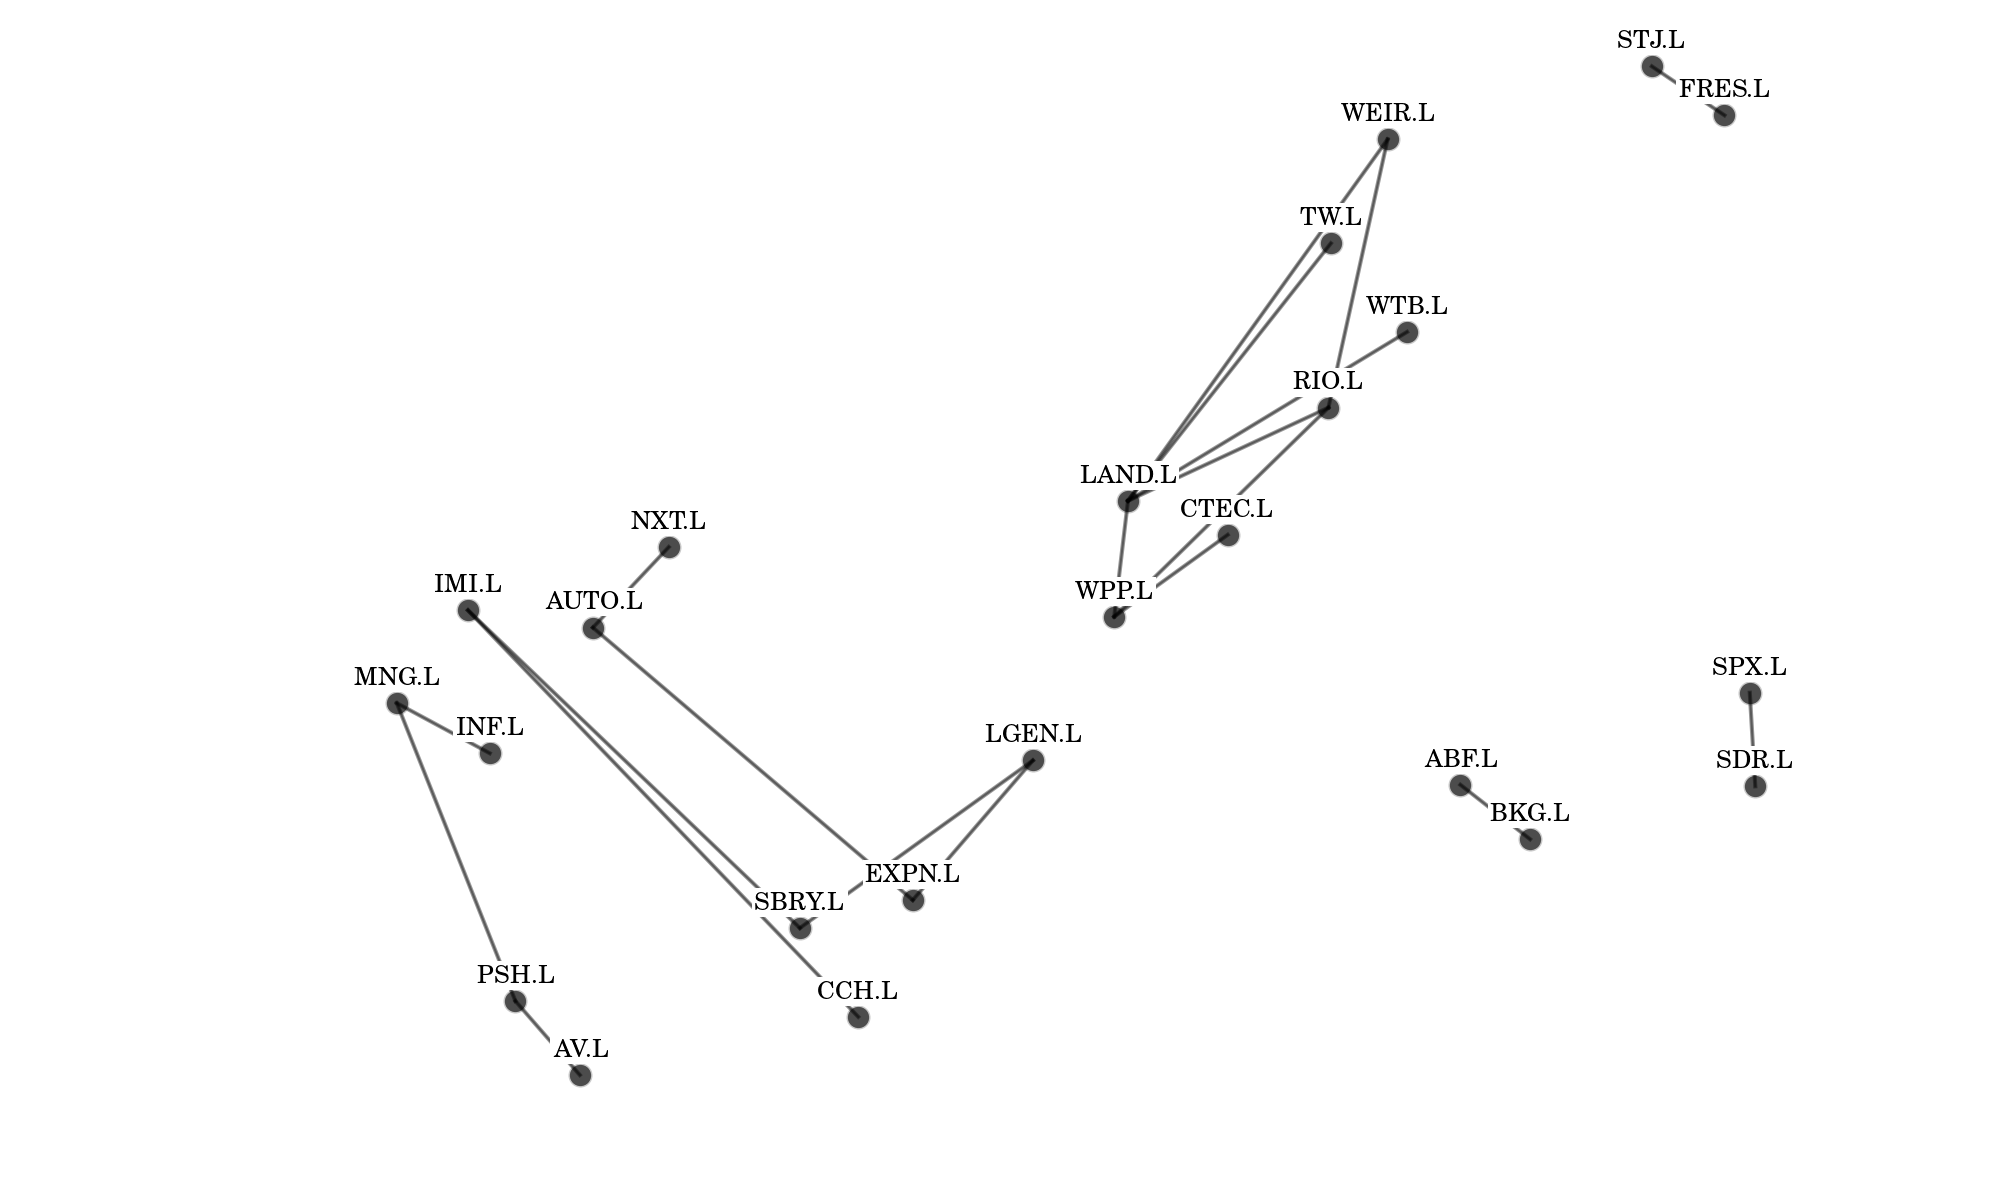

In [79]:
# LaTeX Konfiguration
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

plt.figure(figsize=(20,12), facecolor='white')
plt.clf()
ax = plt.gca()
ax.set_facecolor('white')

# Verbindungslinien zwischen Paaren - alle schwarz, dicker
for pair in top_pairs:
    loc1 = X_pairs.index.get_loc(pair[0])
    loc2 = X_pairs.index.get_loc(pair[1])
    x1, y1 = X_tsne[loc1, :]
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], '-', alpha=0.4, linewidth=3, color='black')
for pair in top_pairs:
    loc1 = X_pairs.index.get_loc(pair[0])
    loc2 = X_pairs.index.get_loc(pair[1])
    x1, y1 = X_tsne[loc1, :]
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], '-', alpha=0.4, linewidth=1.5, color='black')

# Scatter Plot - alle Punkte schwarz
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     s=300,
                     alpha=0.7,
                     color='black',
                     edgecolor='white',
                     linewidth=2)

# Aktien-Labels - noch größere Schrift
for x, y, name in zip(X_tsne[:,0], X_tsne[:,1], X_pairs.index):
    plt.annotate(name,
                (x,y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                va='bottom',
                fontsize=18,
                fontweight='bold',
                bbox=dict(facecolor='white', 
                         edgecolor='none',
                         alpha=1.0,
                         pad=2))

# Keine Überschrift, keine Achsen, keine Colorbar
plt.axis('off')
plt.tight_layout()
plt.show()

In [80]:
def trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2, window_number, window1=window1, window2=window2):
    trades = []
    trade_id = 0
    active_trades = []
    
    S1_full = pd.concat([S1_train, S1_test])
    S2_full = pd.concat([S2_train, S2_test])
    
    ratios_full = S1_full / S2_full
    test_start = S1_test.index[0]
    
    for i in range(len(S1_test)):
        current_idx = S1_train.shape[0] + i
        ratio_history = ratios_full.iloc[:current_idx+1]
        
        if len(ratio_history) < window2:
            continue
            
        ratio_history_past = ratios_full.iloc[:current_idx] 
        ma2 = ratio_history_past.rolling(window=window2, center=False).mean().iloc[-1] 
        std = ratio_history_past.rolling(window=window2, center=False).std().iloc[-1]   
        
        if std == 0:
            continue
            
        current_ratio = ratios_full.iloc[current_idx]
        current_date = S1_test.index[i]
        zscore = (current_ratio - ma2) / std
        
        if zscore > entry_threshold:
            trade_entry = {
                'trade_id': trade_id,
                'symbol1': symbol1,
                'symbol2': symbol2,
                'entry_date': current_date,
                'entry_zscore': zscore,
                'window': window_number,
                'status': 'active',
                'type': 'short',
                'entry_prices': {
                    symbol1: {'price': S1_test.iloc[i], 'type': 'short'},
                    symbol2: {'price': S2_test.iloc[i], 'type': 'long'}
                }
            }
            active_trades.append(trade_entry)
            trade_id += 1
            
        elif zscore < -entry_threshold:
            trade_entry = {
                'trade_id': trade_id,
                'symbol1': symbol1,
                'symbol2': symbol2,
                'entry_date': current_date,
                'entry_zscore': zscore,
                'window': window_number,
                'status': 'active',
                'type': 'long',
                'entry_prices': {
                    symbol1: {'price': S1_test.iloc[i], 'type': 'long'},
                    symbol2: {'price': S2_test.iloc[i], 'type': 'short'}
                }
            }
            active_trades.append(trade_entry)
            trade_id += 1
        
        for trade in active_trades:
            if trade['status'] == 'active':
                if (trade['type'] == 'short' and zscore < exit_threshold) or \
                   (trade['type'] == 'long' and zscore > -exit_threshold):
                    
                    trade['status'] = 'closed'
                    trade['exit_date'] = current_date
                    trade['exit_zscore'] = zscore
                    
                    for symbol in [symbol1, symbol2]:
                        trades.append({
                            'trade_id': trade['trade_id'],
                            'symbol': symbol,
                            'entry_date': trade['entry_date'],
                            'entry_price': trade['entry_prices'][symbol]['price'],
                            'exit_date': current_date,
                            'exit_price': S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i],
                            'position_type': trade['entry_prices'][symbol]['type'],
                            'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                            'exit_type': 'target',
                            'window': trade['window']
                        })
    
    return trades, active_trades

In [81]:
def zscore(series):    
    return (series - series.mean()) / np.std(series)

def calculate_spread(data, symbol1, symbol2, start_date=None, end_date=None):
    if start_date:
        mask = (data.index >= start_date) & (data.index <= end_date)
        data = data[mask]
    
    # Calculate ratio and z-score
    ratios = data[symbol1] / data[symbol2]
    zscore_ratios = zscore(ratios)
    
    return ratios, zscore_ratios

In [82]:
def backtest_pairs_sliding(price_matrix, initial_start_date, initial_end_date, base_output_path, output_filename, window_shifts=window_shifts, p_threshold=p_threshold, shift_size=shift_size):
    all_trades = []
    ongoing_trades = []
    
    print(f"Price Matrix Zeitraum: {price_matrix.index.min()} bis {price_matrix.index.max()}")
    
    for window_number in range(window_shifts):
        current_start = initial_start_date + pd.DateOffset(months=window_number*shift_size)
        current_end = initial_end_date + pd.DateOffset(months=window_number*shift_size)
        
        print(f"\nAnalyse {window_number+1}/{window_shifts}")
        print(f"Cluster-Fenster: {current_start} bis {current_end}")
        
        cluster_data = price_matrix[(price_matrix.index >= current_start) & 
                                  (price_matrix.index <= current_end)].copy()
        
        if len(cluster_data) == 0:
            print(f"Keine Daten für Fenster {window_number+1}")
            continue
            
        print(f"Cluster Daten: {len(cluster_data)} Tage")
            
        metrics = calculate_metrics(cluster_data)
        X = scale_metrics(metrics)
        
        if preference is None:
            ap = AffinityPropagation()
        else:
            ap = AffinityPropagation(preference=preference)
        ap.fit(X)
        
        potential_pairs = []
        
        for cluster_id in np.unique(ap.labels_):
            cluster_mask = ap.labels_ == cluster_id
            cluster_symbols = X.index[cluster_mask]
            center = X.iloc[ap.cluster_centers_indices_[cluster_id]]
            
            for i in range(len(cluster_symbols)):
                for j in range(i+1, len(cluster_symbols)):
                    symbol1, symbol2 = cluster_symbols[i], cluster_symbols[j]
                    
                    dist1 = np.linalg.norm(X.loc[symbol1] - center)
                    dist2 = np.linalg.norm(X.loc[symbol2] - center)
                    center_dist = (dist1 + dist2) / 2
                    profile_diff = np.linalg.norm(X.loc[symbol1] - X.loc[symbol2])
                    
                    series1 = cluster_data[symbol1].dropna()
                    series2 = cluster_data[symbol2].dropna()
                    
                    if len(series1) > 0 and len(series2) > 0:
                        score, pvalue, _ = coint(series1, series2)
                        
                        if pvalue < p_threshold:
                            potential_pairs.append({
                                'pair': (symbol1, symbol2),
                                'center_dist': center_dist,
                                'profile_diff': profile_diff,
                                'pvalue': pvalue,
                                'cluster': cluster_id
                            })
        
        if not potential_pairs:
            print(f"Keine cointegrierten Paare gefunden für Fenster {window_number+1}")
            continue
            
        pairs_df = pd.DataFrame(potential_pairs)
        pairs_df['center_dist_norm'] = (pairs_df['center_dist'] - pairs_df['center_dist'].min()) / \
                                     (pairs_df['center_dist'].max() - pairs_df['center_dist'].min())
        pairs_df['profile_diff_norm'] = (pairs_df['profile_diff'] - pairs_df['profile_diff'].min()) / \
                                      (pairs_df['profile_diff'].max() - pairs_df['profile_diff'].min())
        
        pairs_df['combined_score'] = 0.6 * pairs_df['center_dist_norm'] + \
                                   0.4 * pairs_df['profile_diff_norm']
        
        pairs_df = pairs_df.sort_values('combined_score')
        top_pairs = pairs_df['pair'].tolist()[:min_pairs]
        
        print(f"Gefundene cointegrierte Paare für Fenster {window_number+1}: {len(top_pairs)}")
        
        trade_start = current_end
        trade_end = trade_start + pd.DateOffset(months=1)
        
        print(f"Trading-Zeitraum: {trade_start} bis {trade_end}")
        
        trading_data = price_matrix[(price_matrix.index > trade_start) & 
                                  (price_matrix.index <= trade_end)].copy()
        
        print(f"Trading Daten: {len(trading_data)} Tage")
        
        if len(trading_data) == 0:
            print(f"Warnung: Kein Trading-Zeitraum verfügbar nach {trade_start}")
            continue
            
        updated_ongoing_trades = []
        closed_trade_ids = set()
        
        for open_trade in ongoing_trades:
            symbol1, symbol2 = open_trade['symbol1'], open_trade['symbol2']
            
            if symbol1 in trading_data.columns and symbol2 in trading_data.columns:
                still_active = True
                
                for idx, date in enumerate(trading_data.index):
                    train_data = price_matrix[(price_matrix.index <= open_trade['entry_date'])]
                    ratio_history = train_data[symbol1] / train_data[symbol2]
                    
                    if len(ratio_history) >= window2:
                        ma = ratio_history.rolling(window=window2, center=False).mean().iloc[-1]
                        std = ratio_history.rolling(window=window2, center=False).std().iloc[-1]
                    else:
                        ma = ratio_history.mean()
                        std = ratio_history.std()
                    
                    if std == 0:
                        continue
                    
                    current_ratio = trading_data[symbol1].iloc[idx] / trading_data[symbol2].iloc[idx]
                    current_zscore = (current_ratio - ma) / std
                    
                    if (open_trade['type'] == 'short' and current_zscore < exit_threshold) or \
                       (open_trade['type'] == 'long' and current_zscore > -exit_threshold):
                        
                        open_trade['status'] = 'closed'
                        open_trade['exit_date'] = date
                        closed_trade_ids.add(open_trade['trade_id'])
                        
                        for symbol in [symbol1, symbol2]:
                            all_trades.append({
                                'trade_id': open_trade['trade_id'],
                                'symbol': symbol,
                                'entry_date': open_trade['entry_date'],
                                'entry_price': open_trade['entry_prices'][symbol]['price'],
                                'exit_date': date,
                                'exit_price': trading_data.loc[date, symbol],
                                'position_type': open_trade['entry_prices'][symbol]['type'],
                                'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                                'exit_type': 'target',
                                'window': open_trade['window']
                            })
                        
                        still_active = False
                        break
                
                if still_active:
                    updated_ongoing_trades.append(open_trade)
        
        ongoing_trades = updated_ongoing_trades
        
        trade_count = 0
        for pair in top_pairs:
            symbol1, symbol2 = pair
            
            if symbol1 not in trading_data.columns or symbol2 not in trading_data.columns:
                continue
                
            new_trades, active_new_trades = trade(
                cluster_data[symbol1], 
                cluster_data[symbol2],
                trading_data[symbol1], 
                trading_data[symbol2],
                symbol1, symbol2,
                window_number=window_number + 1
            )
            
            if new_trades:
                trade_count += len(new_trades) // 2 
                all_trades.extend(new_trades)
            
            ongoing_trades.extend(active_new_trades)
        
        print(f"Neue geschlossene Trades in diesem Fenster: {trade_count}")
        print(f"Aktuell offene Trades: {len(ongoing_trades)}")
    
    trades_df = pd.DataFrame(all_trades)
    
    if len(trades_df) > 0:
        
        full_output_path = f"{base_output_path}{output_filename}"
        trades_df.to_parquet(full_output_path)
        
        print("\nTrading Zusammenfassung:")
        print(f"Gesamtanzahl Trades: {len(trades_df)}")
        print(f"Unique Paare gehandelt: {len(trades_df[['symbol', 'paired_symbol']].drop_duplicates())}")
        print(f"Zeitraum: {trades_df['entry_date'].min()} bis {trades_df['exit_date'].max()}")
        
        print("\nTrades pro Fenster:")
        print(trades_df['window'].value_counts().sort_index())
    else:
        print("Keine Trades generiert!")
        
    return trades_df

In [83]:
trades_df = backtest_pairs_sliding(
    price_matrix=price_matrix,
    initial_start_date=DATE_CONFIG['TRAIN_START'],
    initial_end_date=DATE_CONFIG['TRAIN_END'], 
    base_output_path=base_output_path,
    output_filename=output_filename,
    window_shifts=window_shifts
)

Price Matrix Zeitraum: 2021-02-02 00:00:00 bis 2024-12-31 00:00:00

Analyse 1/12
Cluster-Fenster: 2021-02-02 00:00:00 bis 2024-01-01 00:00:00
Cluster Daten: 733 Tage
Gefundene cointegrierte Paare für Fenster 1: 20
Trading-Zeitraum: 2024-01-01 00:00:00 bis 2024-02-01 00:00:00
Trading Daten: 23 Tage
Neue geschlossene Trades in diesem Fenster: 1
Aktuell offene Trades: 44

Analyse 2/12
Cluster-Fenster: 2021-03-02 00:00:00 bis 2024-02-01 00:00:00
Cluster Daten: 736 Tage


KeyboardInterrupt: 

### Debug 🛠️

In [ ]:
print("Gefundene Top Pairs:")
for pair in top_pairs:
    print(f"{pair[0]} - {pair[1]}")
print(f"\nAnzahl der Top Pairs: {len(top_pairs)}")